In [1]:
import pandas as pd
import sqlite3 as sq
import surprise

In [2]:
#Set up data
path = '/db/wrangled_reviews.db'
def import_data(db_path):
    conn = sq.connect(db_path) #sqliteDB path goes in parantheses
    crsr = conn.cursor()

    df = pd.read_sql_query('''
                SELECT *
                FROM trunc_books
                ;
                ''', conn)

    df['star_rating'] = df['star_rating'].astype(float)
    df['star_rating'] = df['star_rating'].astype(int) #convert rating to integer type
    df['helpful_votes'] = df['helpful_votes'].astype(int) #convert rating to integer type

    df['review_body'] = df['review_body'].astype(str) #convert to str
    df['review_headline'] = df['review_headline'].astype(str) #convert to str
    

    return df

df = import_data(path)

In [3]:
df.head(5)
#len(df)
#df.dtypes

,customer_id,product_id,product_parent,star_rating,helpful_votes,review_headline,review_body,product_category,marketplace,review_date,verified_purchase
0,40676812,1938067126,402004849,5,0,Five Stars,Excellent--,Books,US,2015-08-31,Y
1,2784618,014017737X,779170984,5,0,Five Stars,"Arrived before estimated delivery date, just a...",Books,US,2015-08-31,Y
2,2876528,0982207743,225126623,3,1,Three Stars,"Recipes are not complicated, but ingredients a...",Books,US,2015-08-31,Y
3,33678379,080072433X,42136245,3,0,Hard to Get Into,This book I actually had a hard time with. I p...,Books,US,2015-08-31,N
4,32159651,0615815650,625464646,3,1,Run of the mill,I've read quite a few books about persuasion p...,Books,US,2015-08-31,Y


In [4]:
def count_words(data):
   words = data.split(" ")
   num_words = len(words)
   return num_words

df['review_word_count']=0
df['review_hl_count']=0

df['review_word_count'] = df['review_body'].map(count_words)
df['review_hl_count'] = df['review_headline'].map(count_words)


Add in Sentiment Analysis

In [4]:
from textblob import TextBlob
from numpy import interp

In [5]:
def sentiment(row):
    try:
        #raw text of review
        blob = TextBlob(row['review_body'])
        #sentiment polarity score
        polarity = blob.sentiment.polarity
        score = interp(polarity, [-1,1], [1,5])
        return score
    except:
        pass

In [8]:
def clean_sentiment(row):
    try:
        import string
        from nltk.corpus import stopwords

        #split raw text of review into tokens
        words= row['review_body']
        tokens = words.split()

        # remove punctuation from each token
        table = str.maketrans('', '', string.punctuation)
        tokens = [w.translate(table) for w in tokens]

        #remove tokens that are not alphabetic
        tokens = [word for word in tokens if word.isalpha()]

        # filter out stop words
        stop_words = set(stopwords.words('english'))
        tokens = [w for w in tokens if not w in stop_words]

        #convert this list to a string
        blob = ' '.join(tokens)

        #find sentiment of new string and convert to 1-5 scale
        blob = TextBlob(blob)
        polarity = blob.sentiment.polarity
        score = interp(polarity, [-1,1], [1,5])
        return score
    except:
        pass

In [9]:
clean_sentiment(df.loc[1])

3.0

In [10]:
df['sentiment_star_rating'] = df.apply(sentiment,axis=1)
df['cleaned_sentiment_star_rating'] = df.apply(clean_sentiment,axis=1)
df['star_rating']=df['star_rating'].astype(float)
df['difference'] = abs(df['star_rating'] - df['cleaned_sentiment_star_rating'])


In [11]:
df.head(5)

,customer_id,product_id,product_parent,star_rating,helpful_votes,review_headline,review_body,product_category,marketplace,review_date,verified_purchase,sentiment_star_rating,cleaned_sentiment_star_rating,difference
0,40676812,1938067126,402004849,5.0,0,Five Stars,Excellent--,Books,US,2015-08-31,Y,5.000000,5.000000,0.000000
1,2784618,014017737X,779170984,5.0,0,Five Stars,"Arrived before estimated delivery date, just a...",Books,US,2015-08-31,Y,3.000000,3.000000,2.000000
2,2876528,0982207743,225126623,3.0,1,Three Stars,"Recipes are not complicated, but ingredients a...",Books,US,2015-08-31,Y,3.500000,2.000000,1.000000
3,33678379,080072433X,42136245,3.0,0,Hard to Get Into,This book I actually had a hard time with. I p...,Books,US,2015-08-31,N,3.076869,3.009420,0.009420
4,32159651,0615815650,625464646,3.0,1,Run of the mill,I've read quite a few books about persuasion p...,Books,US,2015-08-31,Y,2.624242,2.636364,0.363636


In [12]:
df['sentiment_star_rating'].corr(df['star_rating'])

0.29912622075101331

In [13]:
df['cleaned_sentiment_star_rating'].corr(df['star_rating'])

0.29656177100914144

In [28]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,sentiment_star_rating,cleaned_sentiment_star_rating,difference
count,2.686490e+05,2.686490e+05,268649.000000,268649.000000,268649.000000,268649.000000,268649.000000
mean,3.455033e+07,4.974110e+08,4.265216,3.417292,3.429184,3.420053,1.083261
std,1.466983e+07,2.881033e+08,0.938062,22.510680,0.382828,0.385113,0.595689
min,9.653300e+04,8.165000e+03,1.000000,0.000000,1.000000,1.000000,0.000000
25%,2.104289e+07,2.508276e+08,4.000000,0.000000,3.210777,3.194071,0.588435
50%,3.669379e+07,4.945707e+08,5.000000,0.000000,3.366947,3.361004,1.063889
75%,4.909644e+07,7.471873e+08,5.000000,2.000000,3.554545,3.561608,1.601894
max,5.309639e+07,9.999913e+08,5.000000,2849.000000,5.000000,5.000000,4.000000


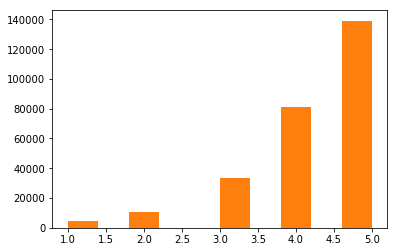

In [30]:
#actual star rating distribution
import matplotlib.pyplot as plt
dataset = df['star_rating']
plt.hist(dataset)
plt.show()

In [45]:
##Percent of star ratings that are 4 and above
len(df[df['star_rating']>=4.0])/len(df)*100

82.01742794501375

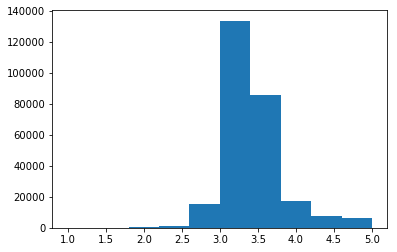

In [31]:
#cleaned sentiment score distribution
dataset2 = df['cleaned_sentiment_star_rating']
plt.hist(dataset2)
plt.show()

In [10]:
len(df)

268649